In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import pandas as pd
from flaml import AutoML

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(
    sorted_dyads_df,
    stress_lookback_days=0,
    sleep_days_to_keep=[1, 2],
)

df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
df_sham = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
df_treat = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_85664/2472178527.py:12: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:141: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  axis=1,


In [87]:
cleaned_dyads_dfs["watch"].columns

Index(['hr_moving_avg_10m', 'hr_moving_std_10m', 'hr_moving_max_10m',
       'hr_moving_min_10m', 'dyad', 'steps_0_to_15m', 'steps_15_to_30m',
       'steps_30_to_45m', 'steps_45_to_60m'],
      dtype='object')

In [76]:
df_train = df_sham
df_test = df_treat

In [77]:
automl = AutoML()

automl_settings = {
    "time_budget": 15,  # seconds
    # "train_time_limit": 1,  # seconds
    "task": "classification",
    "metric": "log_loss",
    "estimator_list": ["xgboost"],
    # "split_type": time_series_split,
    "early_stop": True,
}


X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
print("Best config:", automl.best_config)

[flaml.automl.logger: 01-15 14:27:02] {1752} INFO - task = classification
[flaml.automl.logger: 01-15 14:27:02] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 01-15 14:27:02] {1862} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 01-15 14:27:02] {1979} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 01-15 14:27:02] {2282} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 01-15 14:27:02] {2417} INFO - Estimated sufficient time budget=3714s. Estimated necessary time budget=4s.
[flaml.automl.logger: 01-15 14:27:02] {2466} INFO -  at 1.0s,	estimator xgboost's best error=0.0260,	best estimator xgboost's best error=0.0260
[flaml.automl.logger: 01-15 14:27:02] {2282} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 01-15 14:27:02] {2466} INFO -  at 1.0s,	estimator xgboost's best error=0.0260,	best estimator xgboost's best error=0.0260
[flaml.automl.logger: 01-15 14:27:02] {2282} INFO - iteration 2, cur

In [78]:
import shap
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Fit the model if not already fitted

window = "30m"
X_train, y_train = prep_X_y(df_train, f"tantrum_within_{window}")
X_test, y_test = prep_X_y(df_test, response_column=f"tantrum_within_{window}")
model = XGBClassifier(**automl.best_config)
model.fit(X_train, y_train)


# Predict probabilities for the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.7020


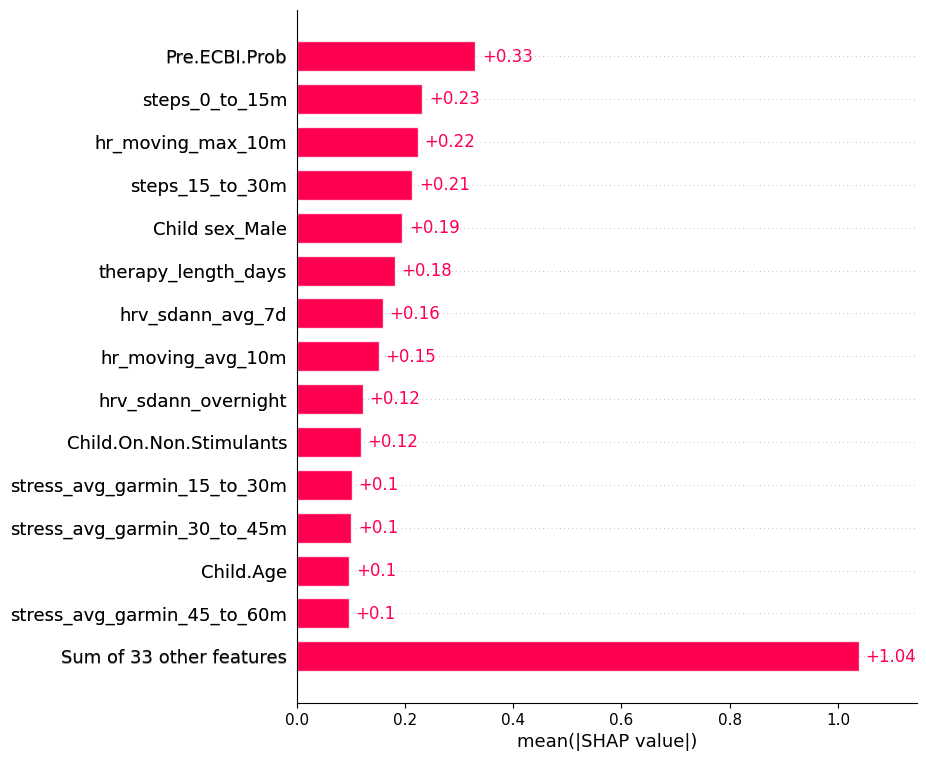

In [79]:
# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
# Note: Bar plot does not accept "group_remaining_features" argument
shap.plots.bar(shap_values, max_display=15)

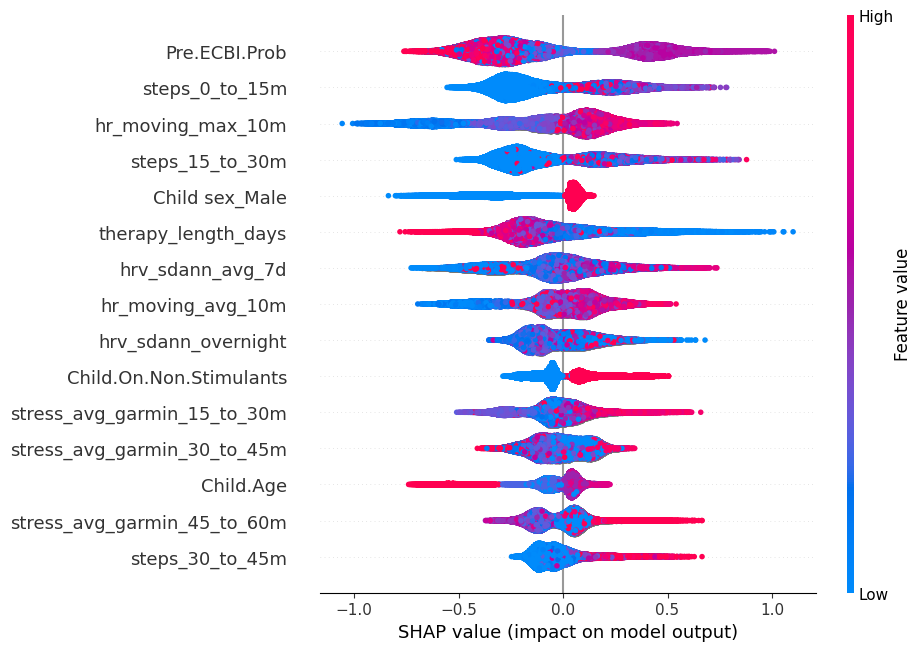

In [80]:
shap.plots.beeswarm(shap_values, max_display=15, group_remaining_features=False)

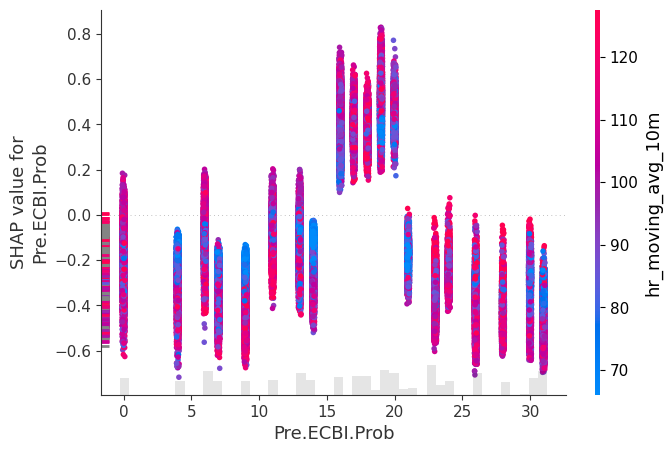

In [81]:
shap.plots.scatter(shap_values[:, "Pre.ECBI.Prob"], color=shap_values)